In [1]:
#Imports

import math
import numpy as np 
from scipy import stats
from scipy.special import logit as lgTransform
from scipy.interpolate import UnivariateSpline
import pandas as pd
import statsmodels.api as sm 
import matplotlib.pylab as plt 
from sklearn.linear_model import LogisticRegression
import statsmodels.formula.api as smf
from statsmodels.formula.api import logit
%matplotlib inline

In [2]:
#Load data

df = pd.read_csv('finalModelcsvs/fake_transcript_variants_LoF_v5_chrom1_new.csv')
#print(df.head())
#print(df.tail())
colDf = df.columns
print(colDf)
print("Number of columns: ", len(colDf))
print("Original df length: ", len(df))
print(df.head())
#print(df.tail())

/Users/Admin/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (44,45,50,51,55,56) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


Index(['chrom', 'pos', 'ref', 'alt', 'gene', 'Consequence', 'UNIPROT_ISOFORM',
       'gnomAD_AF', 'gnomAD_NFE_AF', 'LoF_flags', 'mu', 'qual', 'context',
       'mean', 'median', 'over_t', 'over_5', 'over_10', 'over_15', 'over_20',
       'over_25', 'over_30', 'over_50', 'over_100', 'filter', 'an', 'an_nfe',
       'ac', 'ac_nfe', 'controls_an', 'controls_ac', 'non_cancer_an',
       'non_cancer_ac', 'BaseQRankSum', 'ClippingRankSum', 'DP', 'FS',
       'InbreedingCoeff', 'MQ', 'MQRankSum', 'QD', 'ReadPosRankSum', 'SOR',
       'VQSLOD', 'VQSR_NEGATIVE_TRAIN_SITE', 'VQSR_POSITIVE_TRAIN_SITE',
       'VQSR_culprit', 'allele_type', 'dp_hist_all_n_larger',
       'dp_hist_alt_n_larger', 'has_star', 'lcr', 'n_alt_alleles', 'pab_max',
       'rf_label', 'rf_negative_label', 'rf_positive_label',
       'rf_tp_probability_label', 'interp_dist', 'GIAB', 'ac_unint',
       'ac_nfe_unint'],
      dtype='object')
Number of columns:  62
Original df length:  233400
   chrom     pos ref alt         

In [3]:
#Filtering out bad variants
#freq > 0 &  (ac==0 | filter!="PASS" | has_star | lcr | rf_label=="FP" | allele_type != "snv")

# dfGoodVariants = df[((df['freq'] > 0) & (df['ac'] == 0 | df['filter'] != 'PASS'
#                                         | df['has_star'] == True | df['lcr'] == True 
#                                         | df['rf_label'] == "FP" | df['allele_type'] != "snv"))]

df['freq'] = df['ac_unint'] / df['an']

dfBadVariants = df[df['freq'] > 0]
dfBadVariantsAlleleCount = dfBadVariants[dfBadVariants['ac'] == 0]
dfBadVariantsFilterQuality = dfBadVariants[dfBadVariants['filter'] != 'PASS']
dfBadVariantsHasStar = dfBadVariants[dfBadVariants['has_star'] == True]
dfBadVariantsLCR = dfBadVariants[dfBadVariants['lcr'] == True]
dfBadVariantsRFLabel = dfBadVariants[dfBadVariants['rf_label'] == 'FP']
dfBadVariantsAlleleType = dfBadVariants[dfBadVariants['allele_type'] != 'snv']

dfFinalBadVariants = pd.concat([dfBadVariantsAlleleCount, dfBadVariantsFilterQuality, dfBadVariantsHasStar, dfBadVariantsLCR, dfBadVariantsRFLabel, dfBadVariantsAlleleType], sort=False).sort_index()

print("AC: ", len(dfBadVariantsAlleleCount))
print("Filter: ", len(dfBadVariantsFilterQuality))
print("Has Star: ", len(dfBadVariantsHasStar))
print("LCR: ", len(dfBadVariantsLCR))
print("RF Label", len(dfBadVariantsRFLabel))
print("Allele Type", len(dfBadVariantsAlleleType))

print("Final bad variant set length: ", len(dfFinalBadVariants))
#print(dfFinalBadVariants.head())
#print(dfFinalBadVariants.tail(20))

#print(dfBadVariants['allele_type'].head())

#print("Filter out bad variants length: ", len(dfBadVariants))
#print(dfBadVariants.head())

AC:  0
Filter:  330
Has Star:  405
LCR:  7
RF Label 276
Allele Type 0
Final bad variant set length:  1018


In [4]:
badIndexes = dfFinalBadVariants.index
badSites = dfFinalBadVariants.pos
print(dfFinalBadVariants.index)

df.drop(badIndexes, inplace = True)
dfGoodVariants = df
print(len(dfGoodVariants))
#print(dfGoodVariants.head())
#print(dfGoodVariants.tail())

Int64Index([    61,     61,     75,     90,     90,    119,    122,    144,
               183,    186,
            ...
            229766, 230094, 230248, 230248, 230823, 230886, 230886, 231354,
            231464, 233380],
           dtype='int64', length=1018)
232557


In [5]:
#Coverage and quality filtering
# qual=="high", over_20>0.8,freq==0 & interp_dist==0 & allele_type != "snv", ENSG00000242265

print("Good variants length: ", len(dfGoodVariants))

#Keep sites with high quality
dfQuality = dfGoodVariants[dfGoodVariants['qual'] == 'high']
print("Quality filtering: ", len(dfQuality))

#Keep sites with over_20 coverage > 0.8
dfFilterQuality80 = dfQuality[dfQuality['over_20'] > 0.8]
print(len(dfFilterQuality80))

#Change GIAB from T/F to binary variable
dfFilterQuality80["GIAB"] = dfFilterQuality80["GIAB"].astype(int)

#Filter freq == 0, #Filter interp_distance == 0, #Filter sites allele_type != "snv"
maskCoverage = (dfFilterQuality80['freq'] == 0) & (dfFilterQuality80['interp_dist'] == 0) & (dfFilterQuality80['allele_type'] != 'snv')

dfFilterQuality80FreqInterpAlleleType = dfFilterQuality80[maskCoverage]

# dfFilterQuality80 = dfFilterQuality80[dfFilterQuality80['freq'] != 0]
# dfFilterQuality80 = dfFilterQuality80[dfFilterQuality80['interp_dist'] != 0]
# dfFilterQuality80 = dfFilterQuality80[dfFilterQuality80['allele_type'] == 'snv']

freqInterpAlleleTypeIndexes = dfFilterQuality80FreqInterpAlleleType.index
print(freqInterpAlleleTypeIndexes)
dfFilterQuality80.drop(freqInterpAlleleTypeIndexes, inplace = True)
print(len(dfFilterQuality80))

#Filter sites in the gene ENSG00000242265
dfFilterQuality80 = dfFilterQuality80[dfFilterQuality80['gene'] != 'ENSG00000242265']
print(len(dfFilterQuality80))

#print(dfQuality.head())

print("After filtering for freq == 0 and interp_dist == 0: ", len(dfFilterQuality80))
#print(dfFilterQuality80.head())
#print(dfFilterQuality80.tail())

print(len(dfFilterQuality80FreqInterpAlleleType))
#print(dfFilterQuality80FreqInterpAlleleType.head())

Good variants length:  232557
Quality filtering:  219549
176414
Int64Index([   215,    216,    332,    333,    451,    768,    878,   1415,
              1445,   1802,
            ...
            230385, 230432, 230506, 231139, 231370, 231509, 232319, 233151,
            233152, 233339],
           dtype='int64', length=1426)


<ipython-input-5-f0edf46b95fc>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfFilterQuality80["GIAB"] = dfFilterQuality80["GIAB"].astype(int)


174988
174988
After filtering for freq == 0 and interp_dist == 0:  174988
1426


/Users/Admin/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [6]:
dfFilterQuality80.insert(57, 'CpG_context', [1 for x in range(len(dfFilterQuality80))])
#print(dfFilterQuality80.head())

In [7]:
#CpG Transitions

context = dfFilterQuality80.context.tolist()
ref = dfFilterQuality80.ref.tolist()
alt = dfFilterQuality80.alt.tolist()
CpGArray = np.zeros(len(context))
CpGArrayIndex = 0

for i in range(len(context)):
    contextString = context[i]
    for j in range(len(contextString)-1):
        if (contextString[j] == 'C' and contextString[j+1] == 'G'):
            if ((ref[i] == 'G' and alt[i] == 'A') or (ref[i] == 'C' and alt[i] == 'T')):
                CpGArray[CpGArrayIndex] = 1
    CpGArrayIndex = CpGArrayIndex + 1

# for k in range(100): 
#     print(CpGArray[k])
    
# print(dfFilterQuality80.context.head(50))
# print(len(CpGArray))

dfFilterQuality80['CpG_context'] = CpGArray.tolist()
#dfChuckles = dfFilterQuality80[['context', 'CpG_context']]
#print(dfChuckles.head(50))
print(dfFilterQuality80.head(40))

     chrom     pos ref alt             gene  \
0        1  925933   A   T  ENSG00000187634   
1        1  925980   C   A  ENSG00000187634   
2        1  925986   C   A  ENSG00000187634   
3        1  925995   C   A  ENSG00000187634   
4        1  925996   C   T  ENSG00000187634   
17       1  931053   G   A  ENSG00000187634   
18       1  931054   G   A  ENSG00000187634   
19       1  931073   C   T  ENSG00000187634   
20       1  931076   G   T  ENSG00000187634   
21       1  931087   C   A  ENSG00000187634   
22       1  935773   C   T  ENSG00000187634   
23       1  935836   G   T  ENSG00000187634   
24       1  935842   C   T  ENSG00000187634   
25       1  935853   T   A  ENSG00000187634   
26       1  935854   G   T  ENSG00000187634   
27       1  935860   C   T  ENSG00000187634   
28       1  935863   A   T  ENSG00000187634   
29       1  935875   G   T  ENSG00000187634   
30       1  935887   C   T  ENSG00000187634   
41       1  939319   G   T  ENSG00000187634   
42       1  9

In [8]:
# dfCpG = dfFilterQuality80.loc[dfFilterQuality80['CpG_context'] == 1]
# ref = dfCpG.ref.tolist()
# alt = dfCpG.alt.tolist()
# CpGArrayTransitions = np.zeros(len(dfCpG))
# CpGTransitionsArrayIndex = 0

# for i in range(len(dfCpG)): 
#     if ((ref[i] == 'G' and alt[i] == 'A') or (ref[i] == 'C' and alt[i] == 'T')):
#         CpGArrayTransitions[CpGTransitionsArrayIndex] = 1
#     CpGTransitionsArrayIndex = CpGTransitionsArrayIndex + 1

# for k in range(100):
#     print(CpGArrayTransitions[k])

# #print(CpGArrayTransitions)
# print(len(dfCpG))
# print(dfCpG.head(50))

In [9]:
#Dependent var freq > 0 logistic_freq

dfFilterQuality80.insert(58, 'logistic_freq', [1 for x in range(len(dfFilterQuality80))])
dfFilterQuality80['logistic_freq'] = np.where((dfFilterQuality80.freq == 0), 0, dfFilterQuality80.logistic_freq)
print(dfFilterQuality80.head())

   chrom     pos ref alt             gene  Consequence UNIPROT_ISOFORM  \
0      1  925933   A   T  ENSG00000187634  stop_gained               .   
1      1  925980   C   A  ENSG00000187634  stop_gained               .   
2      1  925986   C   A  ENSG00000187634  stop_gained               .   
3      1  925995   C   A  ENSG00000187634  stop_gained               .   
4      1  925996   C   T  ENSG00000187634  stop_gained               .   

   gnomAD_AF gnomAD_NFE_AF LoF_flags  ...  rf_negative_label  \
0  4.015e-06     8.878e-06         .  ...              False   
1          .             .         .  ...              False   
2          .             .         .  ...              False   
3          .             .         .  ...              False   
4          .             .         .  ...              False   

  rf_positive_label CpG_context  logistic_freq  rf_tp_probability_label  \
0             False         0.0              1                      NaN   
1             False 

In [10]:
#log transform mu
dfFilterQuality80['log_mu'] = np.log10(dfFilterQuality80['mu'])
print(dfFilterQuality80.head())

   chrom     pos ref alt             gene  Consequence UNIPROT_ISOFORM  \
0      1  925933   A   T  ENSG00000187634  stop_gained               .   
1      1  925980   C   A  ENSG00000187634  stop_gained               .   
2      1  925986   C   A  ENSG00000187634  stop_gained               .   
3      1  925995   C   A  ENSG00000187634  stop_gained               .   
4      1  925996   C   T  ENSG00000187634  stop_gained               .   

   gnomAD_AF gnomAD_NFE_AF LoF_flags  ...  rf_positive_label CpG_context  \
0  4.015e-06     8.878e-06         .  ...              False         0.0   
1          .             .         .  ...              False         0.0   
2          .             .         .  ...              False         0.0   
3          .             .         .  ...              False         0.0   
4          .             .         .  ...              False         1.0   

  logistic_freq  rf_tp_probability_label  interp_dist  GIAB  ac_unint  \
0             1          

In [11]:
#log transform mu^2
dfFilterQuality80['log_mu_squared'] = (np.log10(dfFilterQuality80['mu']))**2
print(dfFilterQuality80.head())

   chrom     pos ref alt             gene  Consequence UNIPROT_ISOFORM  \
0      1  925933   A   T  ENSG00000187634  stop_gained               .   
1      1  925980   C   A  ENSG00000187634  stop_gained               .   
2      1  925986   C   A  ENSG00000187634  stop_gained               .   
3      1  925995   C   A  ENSG00000187634  stop_gained               .   
4      1  925996   C   T  ENSG00000187634  stop_gained               .   

   gnomAD_AF gnomAD_NFE_AF LoF_flags  ...  CpG_context logistic_freq  \
0  4.015e-06     8.878e-06         .  ...          0.0             1   
1          .             .         .  ...          0.0             0   
2          .             .         .  ...          0.0             0   
3          .             .         .  ...          0.0             0   
4          .             .         .  ...          1.0             0   

  rf_tp_probability_label  interp_dist  GIAB  ac_unint  ac_nfe_unint  \
0                     NaN            0     1      

In [12]:
#GIAB CpG Interaction
dfFilterQuality80['GIAB_CpG_Interaction'] = dfFilterQuality80['GIAB'] * dfFilterQuality80['CpG_context']
print(dfFilterQuality80.head())

   chrom     pos ref alt             gene  Consequence UNIPROT_ISOFORM  \
0      1  925933   A   T  ENSG00000187634  stop_gained               .   
1      1  925980   C   A  ENSG00000187634  stop_gained               .   
2      1  925986   C   A  ENSG00000187634  stop_gained               .   
3      1  925995   C   A  ENSG00000187634  stop_gained               .   
4      1  925996   C   T  ENSG00000187634  stop_gained               .   

   gnomAD_AF gnomAD_NFE_AF LoF_flags  ...  logistic_freq  \
0  4.015e-06     8.878e-06         .  ...              1   
1          .             .         .  ...              0   
2          .             .         .  ...              0   
3          .             .         .  ...              0   
4          .             .         .  ...              0   

  rf_tp_probability_label interp_dist  GIAB  ac_unint  ac_nfe_unint      freq  \
0                     NaN           0     1       1.0           1.0  0.000004   
1                     NaN       

In [13]:
#Final model Loss of Function

#final_mod = smf.glm('logistic_freq ~ mu + log_mu + log_mu_squared + GIAB + CpG_context + GIAB_CpG_Interaction + median', data = dfFilterQuality80, family = sm.families.Binomial()).fit()
#print(final_mod.summary())

In [14]:
def calculateLogisticProbSynon(intercept, muMod, log_muMod, log_mu_squaredMod, GIABMod, CpG_contextMod, GIAB_CpG_InteractionMod, medianMod, mu, log_mu, log_mu_squared, GIAB, CpG_context, GIAB_CpG_Interaction, median):
        probability = 1 / (1 + math.exp(-1 * ((intercept + (mu * muMod) + (log_muMod * log_mu) + (log_mu_squared * log_mu_squaredMod) + (GIAB * GIABMod) + (CpG_contextMod * CpG_context) + (GIAB_CpG_InteractionMod * GIAB_CpG_Interaction) + (median * medianMod)))))
        return probability
        
interceptMod, muMod, log_muMod, log_mu_squaredMod, GIABMod, CpG_contextMod, GIAB_CpG_InteractionMod, medianMod = 0.1184, 0.8243, 1.9851, -0.1254, 0.0365, 0.0065, -0.2032, 0.0006 #Coefficients for synon final model

In [15]:
dfFilterQuality80['probability_final_mod'] = [1 for x in range(len(dfFilterQuality80))]
probFinalModArray = np.zeros(len(dfFilterQuality80))

muArray = dfFilterQuality80.mu.tolist()
log_muArray = dfFilterQuality80.log_mu.tolist()
log_mu_squaredArray = dfFilterQuality80.log_mu_squared.tolist()
GIABArray = dfFilterQuality80.GIAB.tolist()
CpG_contextArray = dfFilterQuality80.CpG_context.tolist()
GIAB_CpG_InteractionArray = dfFilterQuality80.GIAB_CpG_Interaction.tolist()
medianArray = dfFilterQuality80['median'].tolist()

for i in range(len(dfFilterQuality80)):
    mu = muArray[i]
    log_mu = log_muArray[i]
    log_mu_squared = log_mu_squaredArray[i]
    GIAB = GIABArray[i]
    CpG_context = CpG_contextArray[i]
    GIAB_CpG_Interaction = GIAB_CpG_InteractionArray[i]
    median = medianArray[i]
    
    newProb = calculateLogisticProbSynon(interceptMod, muMod, log_muMod, log_mu_squaredMod, GIABMod, CpG_contextMod, GIAB_CpG_InteractionMod, medianMod, mu, log_mu, log_mu_squared, GIAB, CpG_context, GIAB_CpG_Interaction, median)
    probFinalModArray[i] = newProb
    
dfFilterQuality80['probability_final_mod'] = probFinalModArray
print(dfFilterQuality80.head())

   chrom     pos ref alt             gene  Consequence UNIPROT_ISOFORM  \
0      1  925933   A   T  ENSG00000187634  stop_gained               .   
1      1  925980   C   A  ENSG00000187634  stop_gained               .   
2      1  925986   C   A  ENSG00000187634  stop_gained               .   
3      1  925995   C   A  ENSG00000187634  stop_gained               .   
4      1  925996   C   T  ENSG00000187634  stop_gained               .   

   gnomAD_AF gnomAD_NFE_AF LoF_flags  ...  rf_tp_probability_label  \
0  4.015e-06     8.878e-06         .  ...                      NaN   
1          .             .         .  ...                      NaN   
2          .             .         .  ...                      NaN   
3          .             .         .  ...                      NaN   
4          .             .         .  ...                      NaN   

  interp_dist GIAB  ac_unint  ac_nfe_unint      freq    log_mu  \
0           0    1       1.0           1.0  0.000004 -1.886057   
1 

92
   mu_bins
0    0.004
1    0.013
2    0.020
3    0.030
4    0.041
[7.0000e+00 3.4024e+04 4.5050e+04 2.4534e+04 1.3056e+04 7.8720e+03
 5.0020e+03 4.0940e+03 4.6910e+03 5.9150e+03 6.9570e+03 6.3390e+03
 4.8320e+03 3.4000e+03 2.0730e+03 1.2820e+03 8.9500e+02 5.7100e+02
 4.0600e+02 2.8100e+02 1.7200e+02 1.4600e+02 9.9000e+01 6.1000e+01
 5.5000e+01 4.2000e+01 3.0000e+01 2.4000e+01 1.9000e+01 1.9000e+01
 1.2000e+01 1.5000e+01 6.0000e+00 4.0000e+00 4.0000e+00 5.0000e+00
 6.0000e+00 3.0000e+00 2.0000e+00 3.0000e+00 1.0000e+00 1.0000e+00
 1.0000e+00 4.0000e+00 1.0000e+00 2.0000e+00 2.0000e+00 1.0000e+00
 3.0000e+00 1.0000e+00 1.0000e+00 3.0000e+00 2.0000e+00 1.0000e+01
 3.0000e+00 3.0000e+00 2.0000e+00 1.2000e+01 2.0000e+00 3.0000e+00
 3.0000e+00 5.0000e+00 1.1000e+01 5.0000e+00 9.0000e+00 1.0000e+01
 2.5000e+01 2.1000e+01 1.9000e+01 2.3000e+01 2.9000e+01 2.8000e+01
 6.4000e+01 4.6000e+01 7.0000e+01 1.3400e+02 6.7000e+01 1.5400e+02
 1.4700e+02 1.5500e+02 2.1900e+02 2.2600e+02 2.0400e+02 3.35

(array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05,
        1.e+06]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

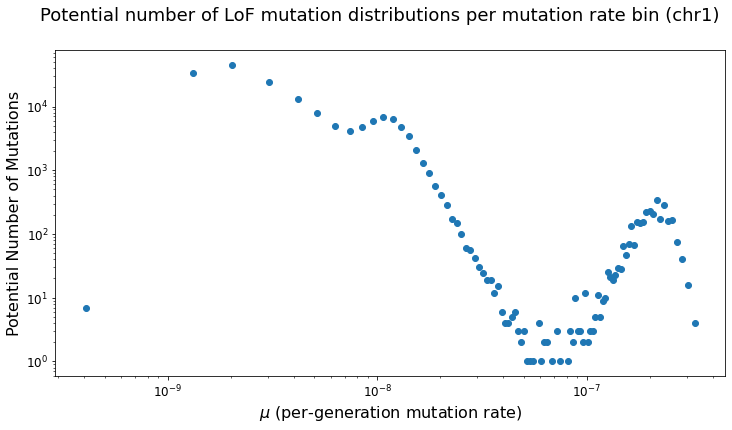

In [16]:
muBins = dfFilterQuality80.mu.unique()
muBins = np.sort(muBins)

dfMuBins = pd.DataFrame(data = muBins)
dfMuBins.columns = ['mu_bins']
print(len(dfMuBins))
print(dfMuBins.head())

freqMu = np.zeros(len(muBins))

for i in range(len(muBins)):
    dfFilterQuality80Plot = dfFilterQuality80[dfFilterQuality80['mu'] == muBins[i]]
    freqMu[i] = len(dfFilterQuality80Plot)
    
print(freqMu)

dfMuBins['freq'] = freqMu.tolist()

perGenConstant = 1.01482054e-7
dfMuBins['mu_bins'] = dfMuBins['mu_bins'] * perGenConstant

print(dfMuBins.head())

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,6))
plt.xscale("log")
plt.yscale("log")
plt.scatter(dfMuBins['mu_bins'], dfMuBins['freq'])

fig.suptitle('Potential number of LoF mutation distributions per mutation rate bin (chr1)', fontsize=18)

plt.xlabel('$\mu$ (per-generation mutation rate)',  fontsize=16)
plt.xticks(fontsize=12)

plt.ylabel('Potential Number of Mutations',  fontsize=16)
plt.yticks(fontsize=12)

In [17]:
#dfMuBins.to_csv('LoF_mu_num_mutations.csv', index=False) #Uncomment this line to store df as a csv